<a href="https://colab.research.google.com/github/AtSourav/Beta-VAE-on-MNIST/blob/main/MNIST_varying_beta_l12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt


In [2]:
input_size = (28,28,1)
latent_dim = 12
batch_size = 64

# **Loading the dataset**

In [3]:
(img_train, tg_train), (img_valid, tg_valid) = mnist.load_data()

img_ht = img_train.shape[1]
img_wd = img_train.shape[2]
count_train = img_train.shape[0]
count_valid = img_valid.shape[0]

img_train = img_train.reshape(count_train,img_ht,img_wd, 1)
img_valid = img_valid.reshape(count_valid,img_ht,img_wd, 1)

img_train = img_train/255.
img_valid = img_valid/255.

print(img_train.shape)
print(img_valid.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
# we'll keep a train:valid split of 80:20, so we'll keep only 40k of the training images. this is to save some time training.

In [5]:
img_train = img_train[:40000]
print(img_train.shape)

(40000, 28, 28, 1)


# **Defining the model**

In [6]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(8, 2, padding="valid")(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(16, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)


x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(arg):
  z_m, z_log_v = arg
  batch = tf.shape(z_m)[0]
  dim = tf.shape(z_m)[1]
  eps = tf.random.normal(shape=(batch,dim))
  return z_m + tf.exp(0.5*z_log_v)*eps

z = layers.Lambda(sampling)([z_mean,z_log_var])

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 27, 27, 8) │         40 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14, 8) │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 14, 14, 8) │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 13, 13,    │        528 │ re_lu[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 6, 6, 16)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 6, 6, 16)  │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 5, 5, 32)  │      2,080 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 4, 4, 32)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3, 3, 32)  │      4,128 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 2, 2, 32)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 2, 2, 32)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 64)  │      8,256 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 1, 1, 64)  │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24)        │      1,560 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 24)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 12)        │        300 │ re_lu_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 12)        │        300 │ re_lu_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 12)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 17,192 (67.16 KB)

 Trainable params: 17,192 (67.16 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(32)(x)
x = layers.ReLU()(x)

x = layers.Dense(64)(x)
x = layers.ReLU()(x)

x = layers.Reshape((1,1,64))(x)

x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(8, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(1, 2, activation='sigmoid', strides=2, padding='same')(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 2, 2, 32)       │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 4, 4, 32)       │         4,128 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 8, 8, 16)       │         2,064 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 8)      │           520 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 1)      │            33 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
decoder_out = decoder(encoder(encoder_input)[2])
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 12), (None,    │        17,192 │
│                                 │ 12), (None, 12)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │        18,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,385 (138.22 KB)

 Trainable params: 35,385 (138.22 KB)

 Non-trainable params: 0 (0.00 B)

## **beta = 1**

In [9]:
beta=1

def vae_loss_1(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [10]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100000, decay_rate=0.993, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss_1)

In [11]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=2, steps_per_epoch=None)

Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 289.5664 - val_loss: 192.7813
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 191.3895 - val_loss: 182.5735


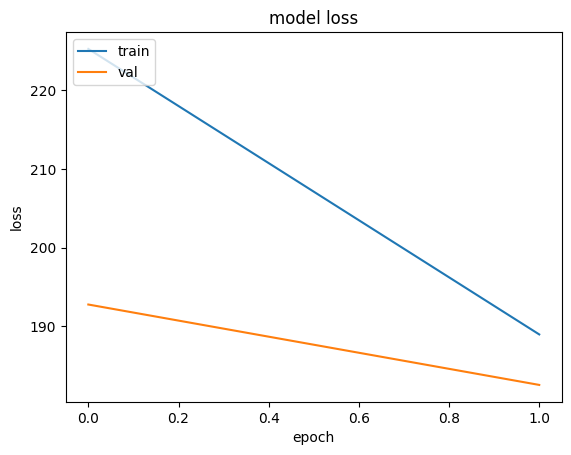

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
def plot_reconstruction(set, name,seed_val, epochs, beta):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 100)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  _,_,z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  digits_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  digits_recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, beta='+str(beta)+', latent_dim = 12', fontweight= 'bold', y=0.93)

  digits_recon.tight_layout()

  for i in range(210):
    digits_recon.add_subplot(10,21,i+1)
    j = int(np.floor(i/21))
    if (i%21) <10:
      img = set[tg_indices[j*10 + (i%21)]]
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    elif (i%21)==10:
      img = np.ones((14,14,1))
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    else:
      img = img_recon[j*10 + (i%21) - 11]
      plt.imshow(img, cmap='gray')
      plt.axis('off')

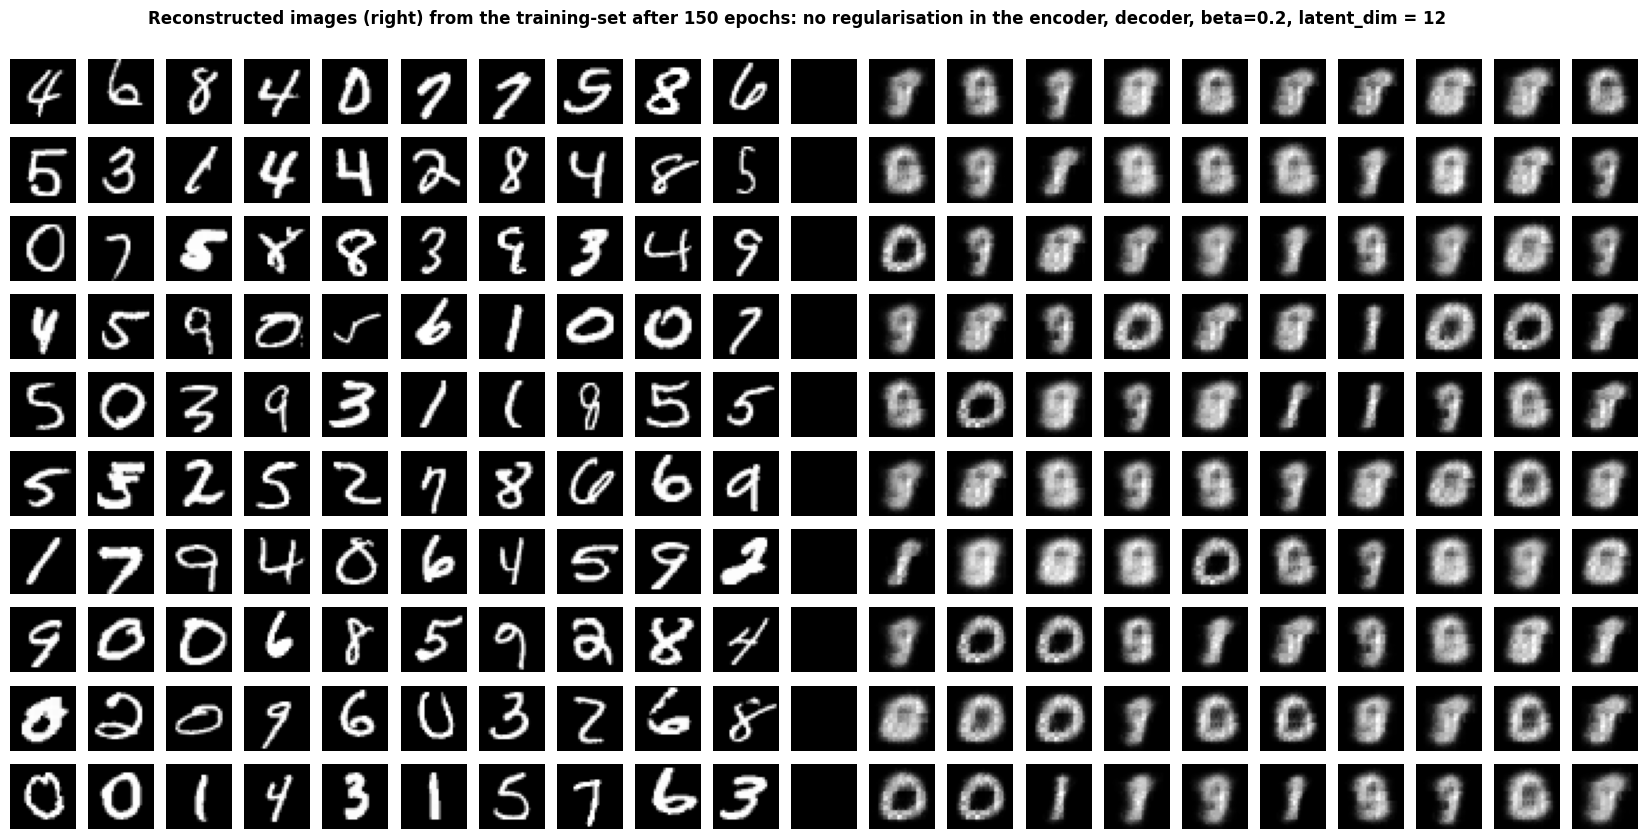

In [14]:
plot_reconstruction(img_train,'training',200,150,0.2)

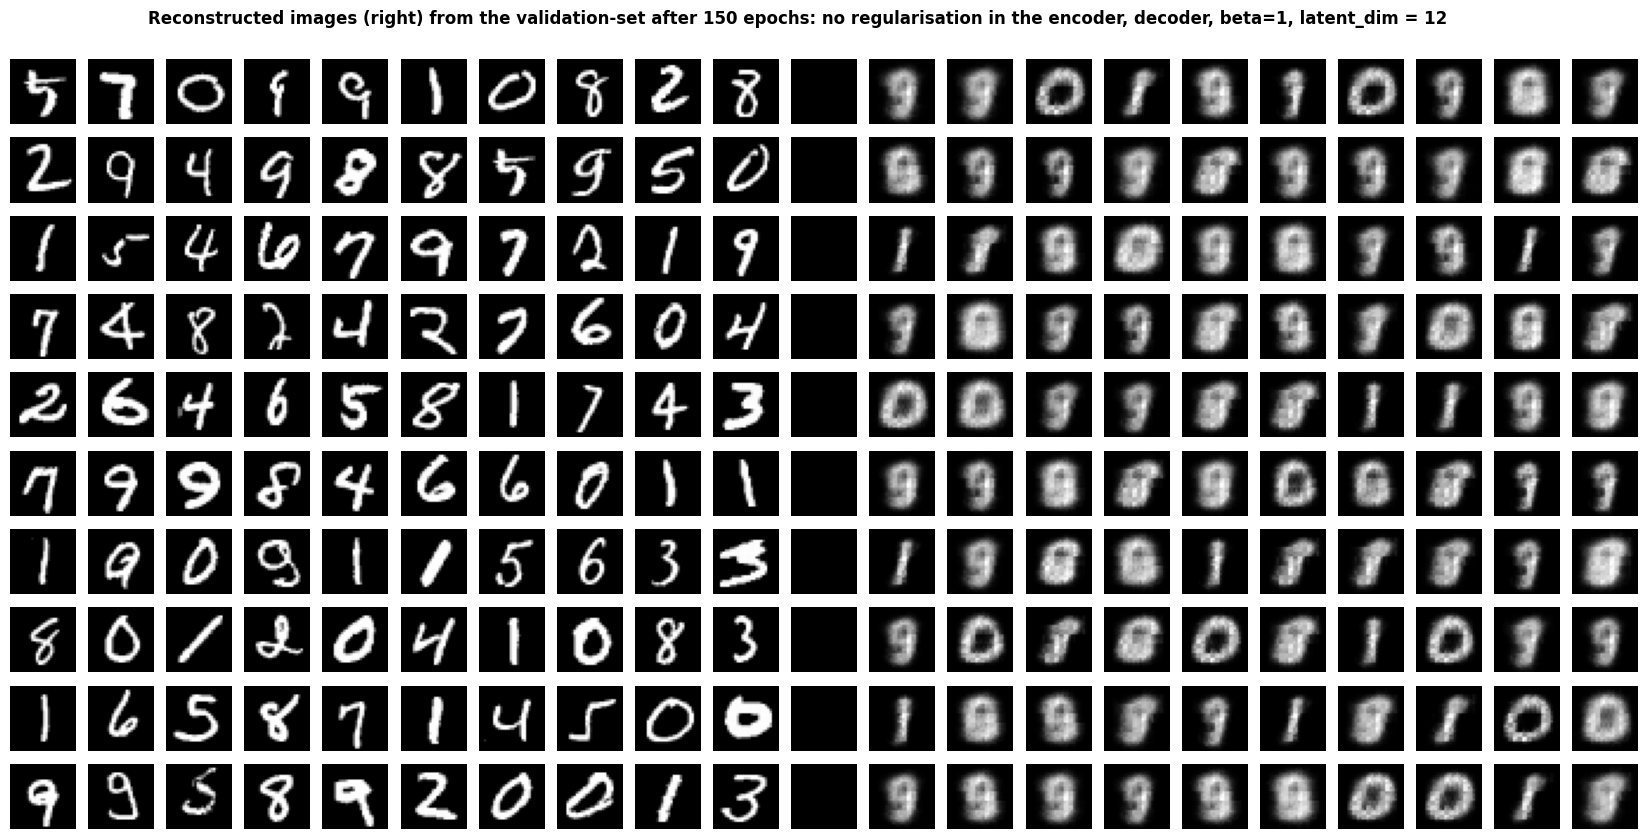

In [15]:
plot_reconstruction(img_valid,'validation',500,150,1)

In [16]:
def plot_generated(scale,edge, seed_val, epochs, beta):   # edge is the length of the square grid we want to create
  np.random.seed(seed_val)
  z_rand = tf.convert_to_tensor(-scale + 2*scale*np.random.random((edge**2,latent_dim)))

  img_rand = decoder(z_rand)

  digits_rand = plt.figure(figsize=(edge,edge))
  digits_rand.suptitle('Some randomly generated images (after '+ str(epochs) + ' epochs of training): no regularisation in the encoder, decoder, beta='+str(beta)+'1, latent_dim = 12', fontweight= 'bold', y=0.93)


  for i in range(edge**2):
    digits_rand.add_subplot(edge,edge,i+1)
    img = img_rand[i]
    plt.imshow(img, cmap='gray')
    plt.axis('off')



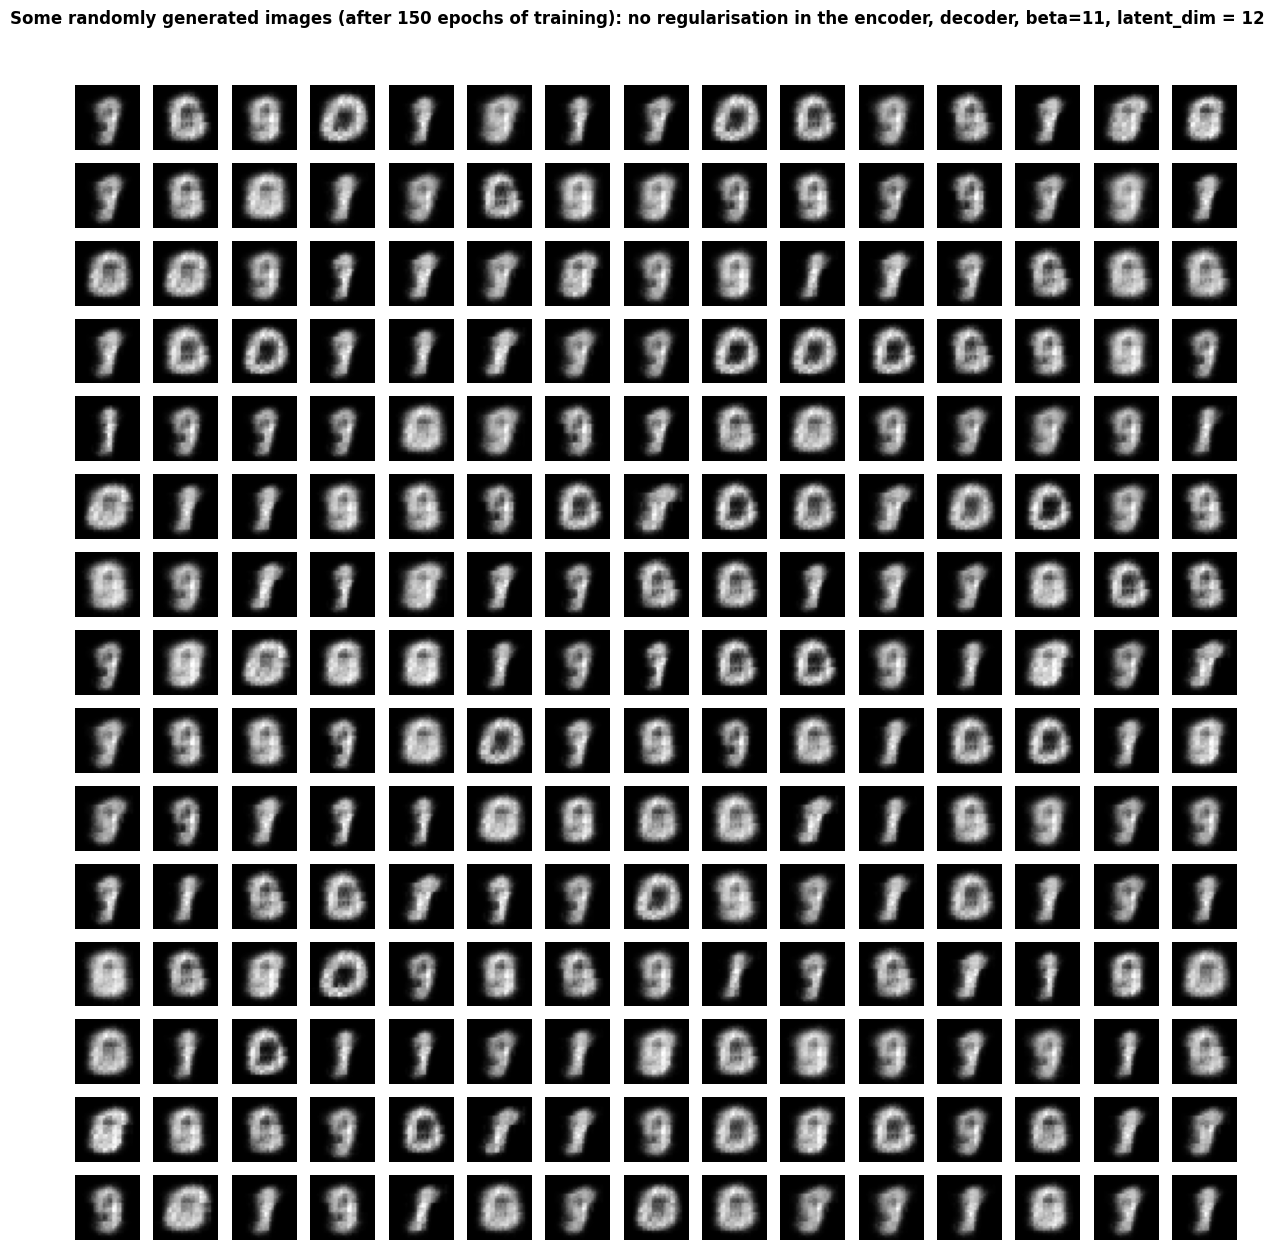

In [19]:
plot_generated(2,15,111,150, beta)

From an inspection of the images, it seems like the training set images are indeed reconstructed slightly better than the validation set images. This is understandable as the loss plots seems to indicate that the performance is very slightly better on the training set than on the validation set.   

We shall take this to further extremes by taking a low value of beta which should suppress the kl div term w.r.t. the reconstruction term.

## **beta=0.01**

In [20]:
beta=0.01

def vae_loss_2(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [21]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100000, decay_rate=0.994, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss_2)

In [23]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, steps_per_epoch=None)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 107.1336 - val_loss: 105.8824
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 106.2668 - val_loss: 104.7864
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 105.6683 - val_loss: 104.0138
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 104.7062 - val_loss: 103.2916
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 104.0180 - val_loss: 102.4780
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 103.0626 - val_loss: 102.1791
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 101.9264 - val_loss: 101.5194
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 101.8918 - val_loss: 100.5923
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 101.3665 - val_loss: 101.5130
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 101.0498 - val_loss: 99.9168
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 100.5408 - val_loss: 99.3922

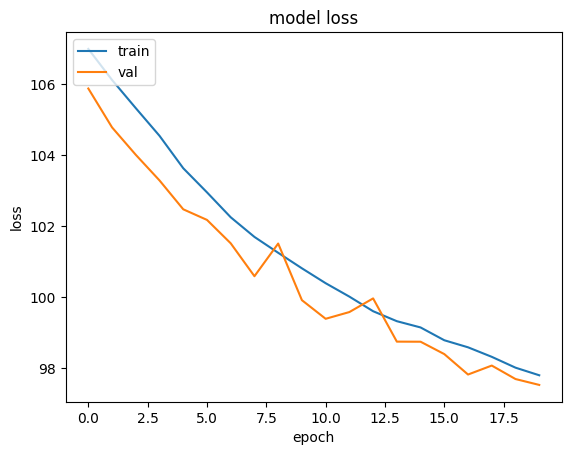

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

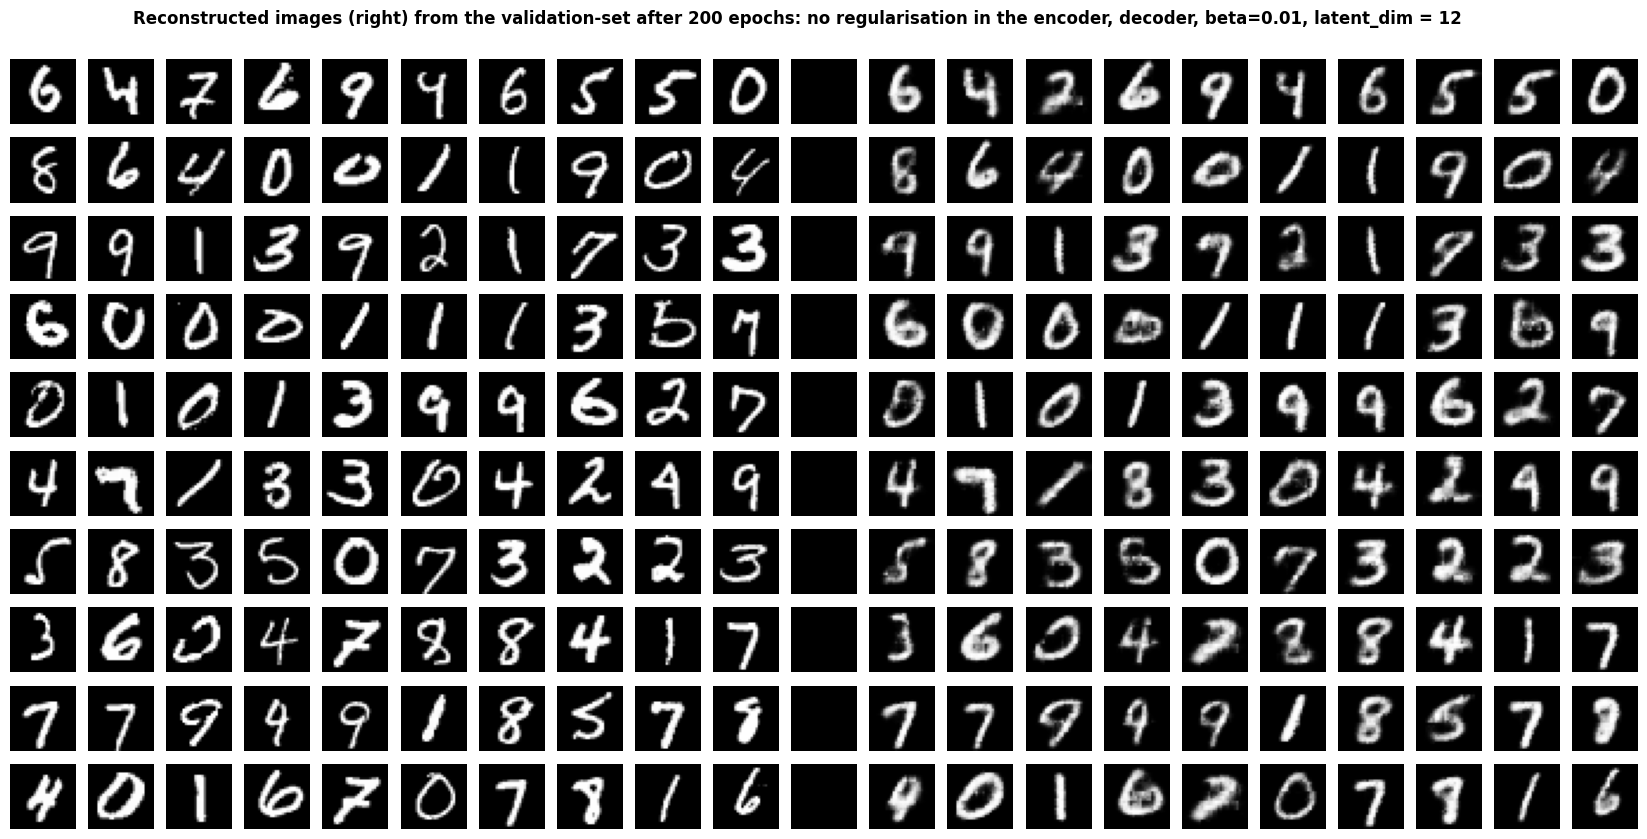

In [26]:
plot_reconstruction(img_valid,'validation',200,200, beta)

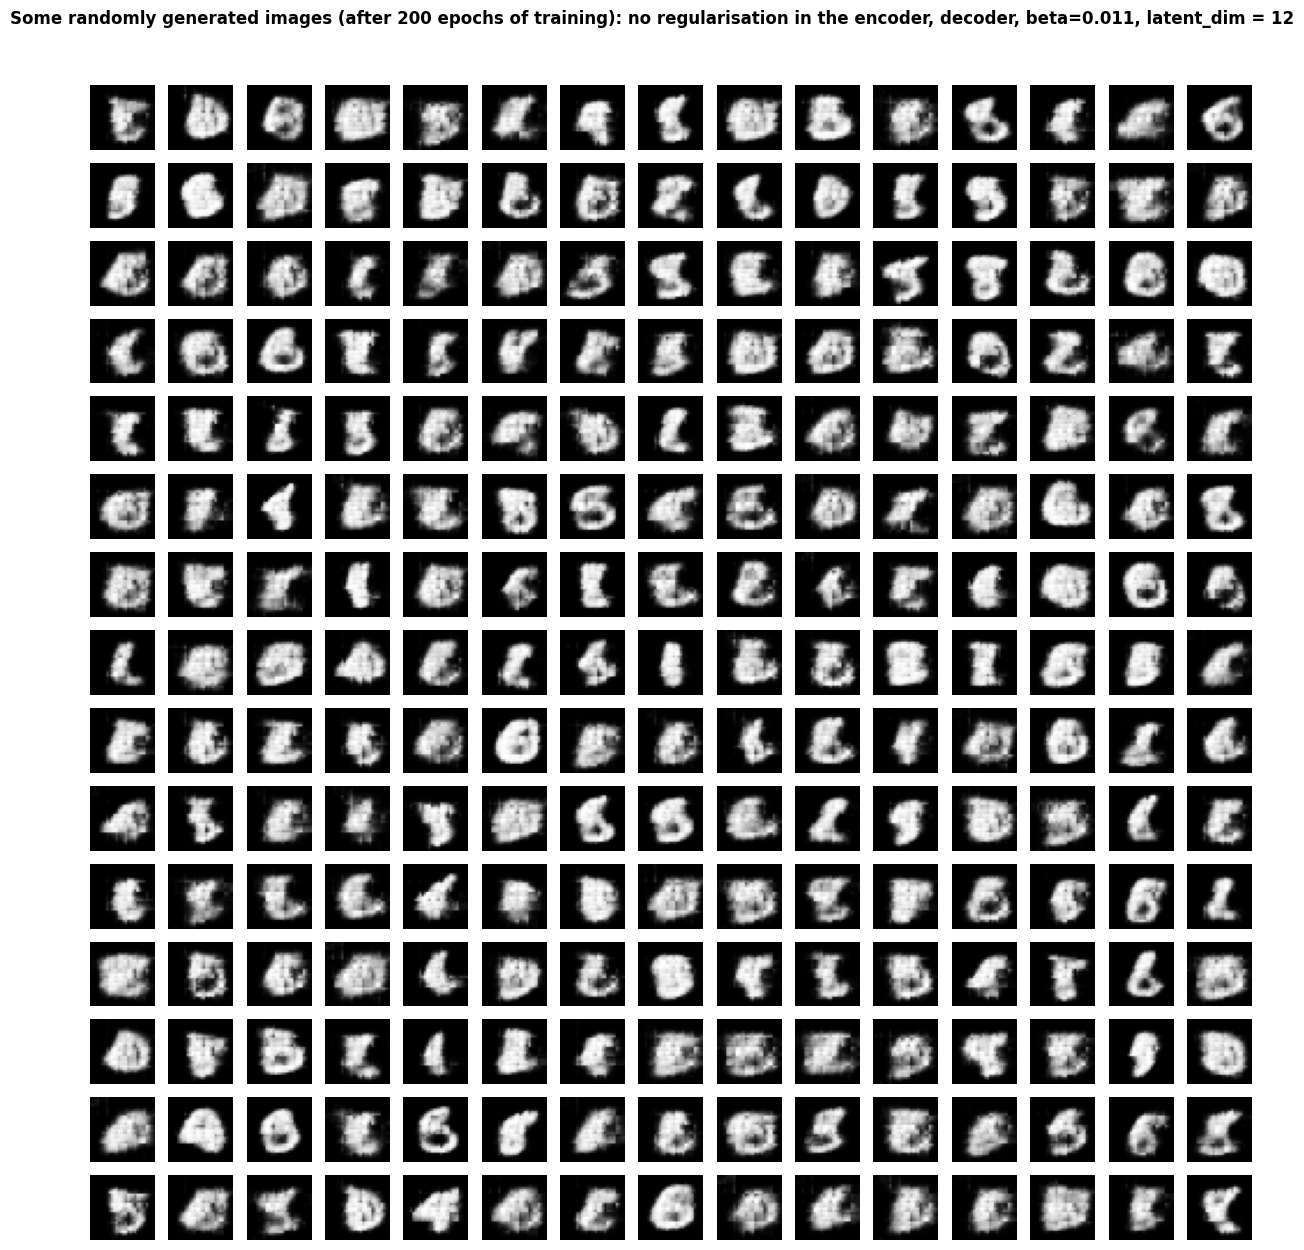

In [28]:
plot_generated(1,15,111,200, beta)

## **beta=10**

In [29]:
beta=10

def vae_loss_3(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [30]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=50000, decay_rate=0.9885, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss_3)

In [32]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=25, steps_per_epoch=None)

Epoch 1/25
  5/625 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 204.5027 

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 199.3416 - val_loss: 195.0341
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 194.3448 - val_loss: 190.6927
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 190.9980 - val_loss: 189.4017
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 189.8125 - val_loss: 188.2098
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 188.8082 - val_loss: 187.7748
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 188.3460 - val_loss: 187.9067
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 187.5714 - val_loss: 187.2564
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 187.5343 - val_loss: 187.0295
Epoch 9/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 186.8872 - val_loss: 186.7070
Epoch 10/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 186.9693 - val_loss: 186.5328
Epoch 11/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 186.5733 - val_loss: 185.3992
Epoch 

In [33]:
#lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=50000, decay_rate=0.9885, staircase=True)
optim = keras.optimizers.Adam(learning_rate = 0.0005)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history2 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 184.7100 - val_loss: 183.8166
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 184.4796 - val_loss: 183.9267
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 184.0879 - val_loss: 183.8821
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 184.3094 - val_loss: 184.1981
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 184.1691 - val_loss: 183.7314
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 184.0443 - val_loss: 183.9141
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 183.8163 - val_loss: 183.6516
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 184.1602 - val_loss: 183.4553
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 184.1181 - val_loss: 183.6387
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 183.7544 - val_loss: 183.7318


In [34]:
optim = keras.optimizers.Adam(learning_rate = 0.0002)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history3 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 183.3041 - val_loss: 183.0976
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 183.3494 - val_loss: 183.5274
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 183.1883 - val_loss: 183.0221
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 183.3587 - val_loss: 182.7584
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 183.2191 - val_loss: 183.1209
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 183.2813 - val_loss: 182.9130
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 183.1446 - val_loss: 182.7638
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 183.0873 - val_loss: 183.0282
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 183.2819 - val_loss: 182.8675
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 183.4367 - val_loss: 182.8999


In [35]:
optim = keras.optimizers.Adam(learning_rate = 0.0001)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history4 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 183.2826 - val_loss: 182.8795
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.3386 - val_loss: 182.7099
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.4238 - val_loss: 182.6333
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.9097 - val_loss: 182.4764
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.9723 - val_loss: 182.5598
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.1233 - val_loss: 182.6259
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.1157 - val_loss: 182.6918
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.0461 - val_loss: 182.8813
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.0190 - val_loss: 182.7475
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 183.4202 - val_loss: 182.8385


In [36]:
optim = keras.optimizers.Adam(learning_rate = 0.00009)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history5 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 183.0850 - val_loss: 182.7174
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.9019 - val_loss: 182.4309
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.1740 - val_loss: 182.6515
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.7569 - val_loss: 182.7369
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.5852 - val_loss: 182.5388
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 183.2179 - val_loss: 182.3865
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.2177 - val_loss: 182.3451
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.2298 - val_loss: 182.5135
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.8088 - val_loss: 182.5488
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 183.2533 - val_loss: 182.7489


In [37]:
optim = keras.optimizers.Adam(learning_rate = 0.000075)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history6 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 182.5743 - val_loss: 182.6887
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 183.0050 - val_loss: 182.4779
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.5196 - val_loss: 182.5691
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 182.8474 - val_loss: 182.5199
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 182.6780 - val_loss: 182.6106
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 182.5211 - val_loss: 182.4749
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 182.9661 - val_loss: 182.5318
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 182.8308 - val_loss: 182.7203
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 183.1332 - val_loss: 182.7515
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 183.0001 - val_loss: 182.5165


In [38]:
optim = keras.optimizers.Adam(learning_rate = 0.00003)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history7 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 182.9505 - val_loss: 182.3973
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.0818 - val_loss: 182.2520
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.8667 - val_loss: 182.5611
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.8312 - val_loss: 182.6253
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.5898 - val_loss: 182.2544
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.7242 - val_loss: 182.3028
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.8392 - val_loss: 182.5334
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 182.7435 - val_loss: 182.1352
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.5860 - val_loss: 182.4816
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 182.5240 - val_loss: 182.3247


In [39]:
optim = keras.optimizers.Adam(learning_rate = 0.000009)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history8 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 182.3509 - val_loss: 182.4709
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.4946 - val_loss: 182.5531
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.4949 - val_loss: 182.6133
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.6202 - val_loss: 182.5324
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.5340 - val_loss: 182.4962
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.2186 - val_loss: 182.6666
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 182.7077 - val_loss: 182.4199
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 183.1140 - val_loss: 182.5277
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.6890 - val_loss: 182.6760
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.7443 - val_loss: 182.5146


In [40]:
optim = keras.optimizers.Adam(learning_rate = 0.000005)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history9 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 182.4812 - val_loss: 182.3887
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.8400 - val_loss: 182.3441
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.6619 - val_loss: 182.5137
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 182.4823 - val_loss: 182.2214
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.7702 - val_loss: 182.5199
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.6721 - val_loss: 182.7145
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.5680 - val_loss: 182.7158
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.0690 - val_loss: 182.2228
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.0954 - val_loss: 182.3634
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 182.9505 - val_loss: 182.4648


In [41]:
optim  = keras.optimizers.Adam(learning_rate = 0.0000009)
VAE.compile(optimizer=optim,loss=vae_loss_3)

history10 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, steps_per_epoch=None)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 182.8798 - val_loss: 182.3948
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 183.1388 - val_loss: 182.6176
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 182.6435 - val_loss: 182.0441
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.3923 - val_loss: 182.2546
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.5277 - val_loss: 182.4221
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.1163 - val_loss: 182.5328
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.6642 - val_loss: 182.4184
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 182.7515 - val_loss: 182.1269
Epoch 9/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.7295 - val_loss: 182.1923
Epoch 10/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.2323 - val_loss: 182.5886
Epoch 11/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 182.6805 - val_l

we'll stop here, we don't expect it to improve much beyond this.

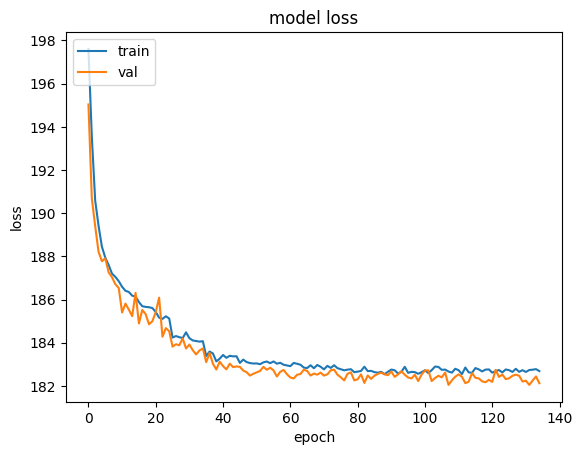

In [42]:
comb_hist_loss = history.history['loss'] + history2.history['loss'] + history3.history['loss'] + history4.history['loss'] + history5.history['loss'] + history6.history['loss'] + history7.history['loss'] + history8.history['loss'] + history9.history['loss'] + history10.history['loss']
comb_hist_val_loss = history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'] + history4.history['val_loss'] + history5.history['val_loss'] + history6.history['val_loss'] + history7.history['val_loss'] + history8.history['val_loss'] + history9.history['val_loss'] + history10.history['val_loss']

plt.plot(comb_hist_loss)
plt.plot(comb_hist_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

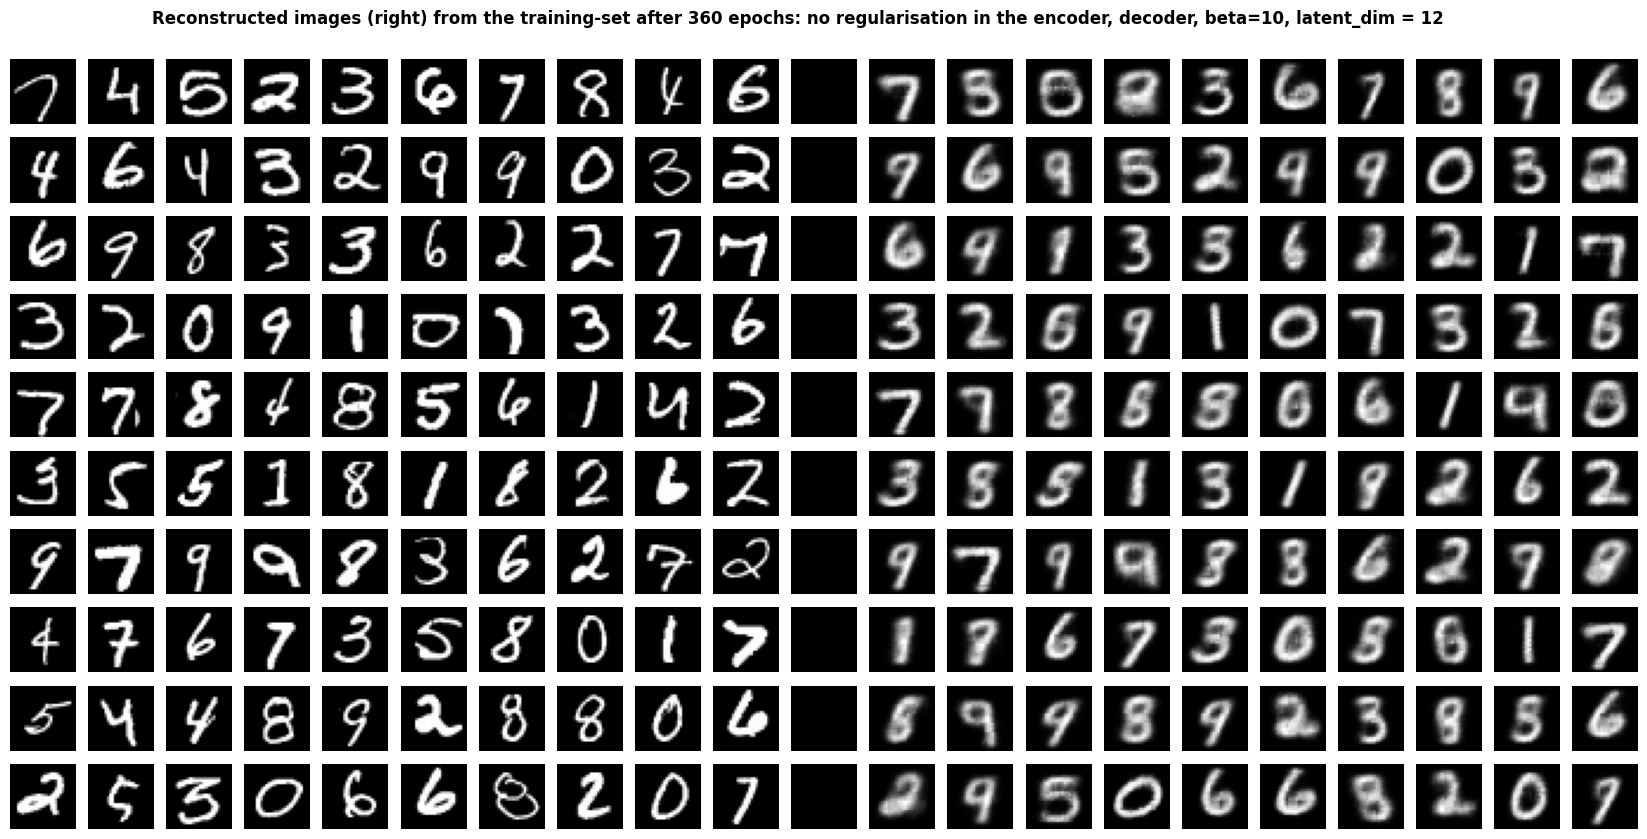

In [43]:
plot_reconstruction(img_train,'training',111,360,10)

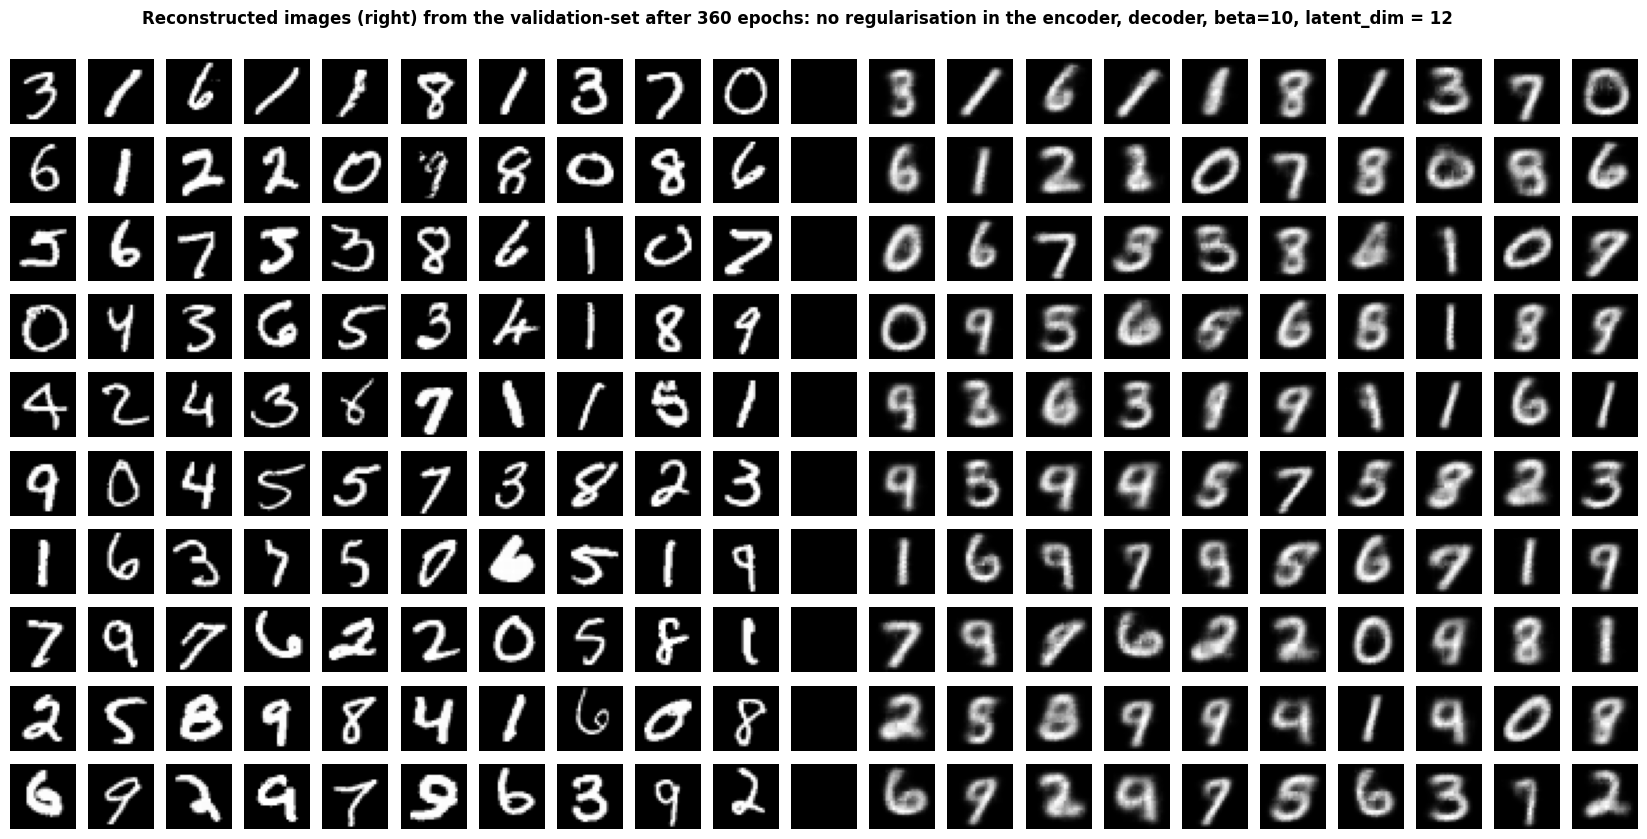

In [44]:
plot_reconstruction(img_valid,'validation',555,360,10)

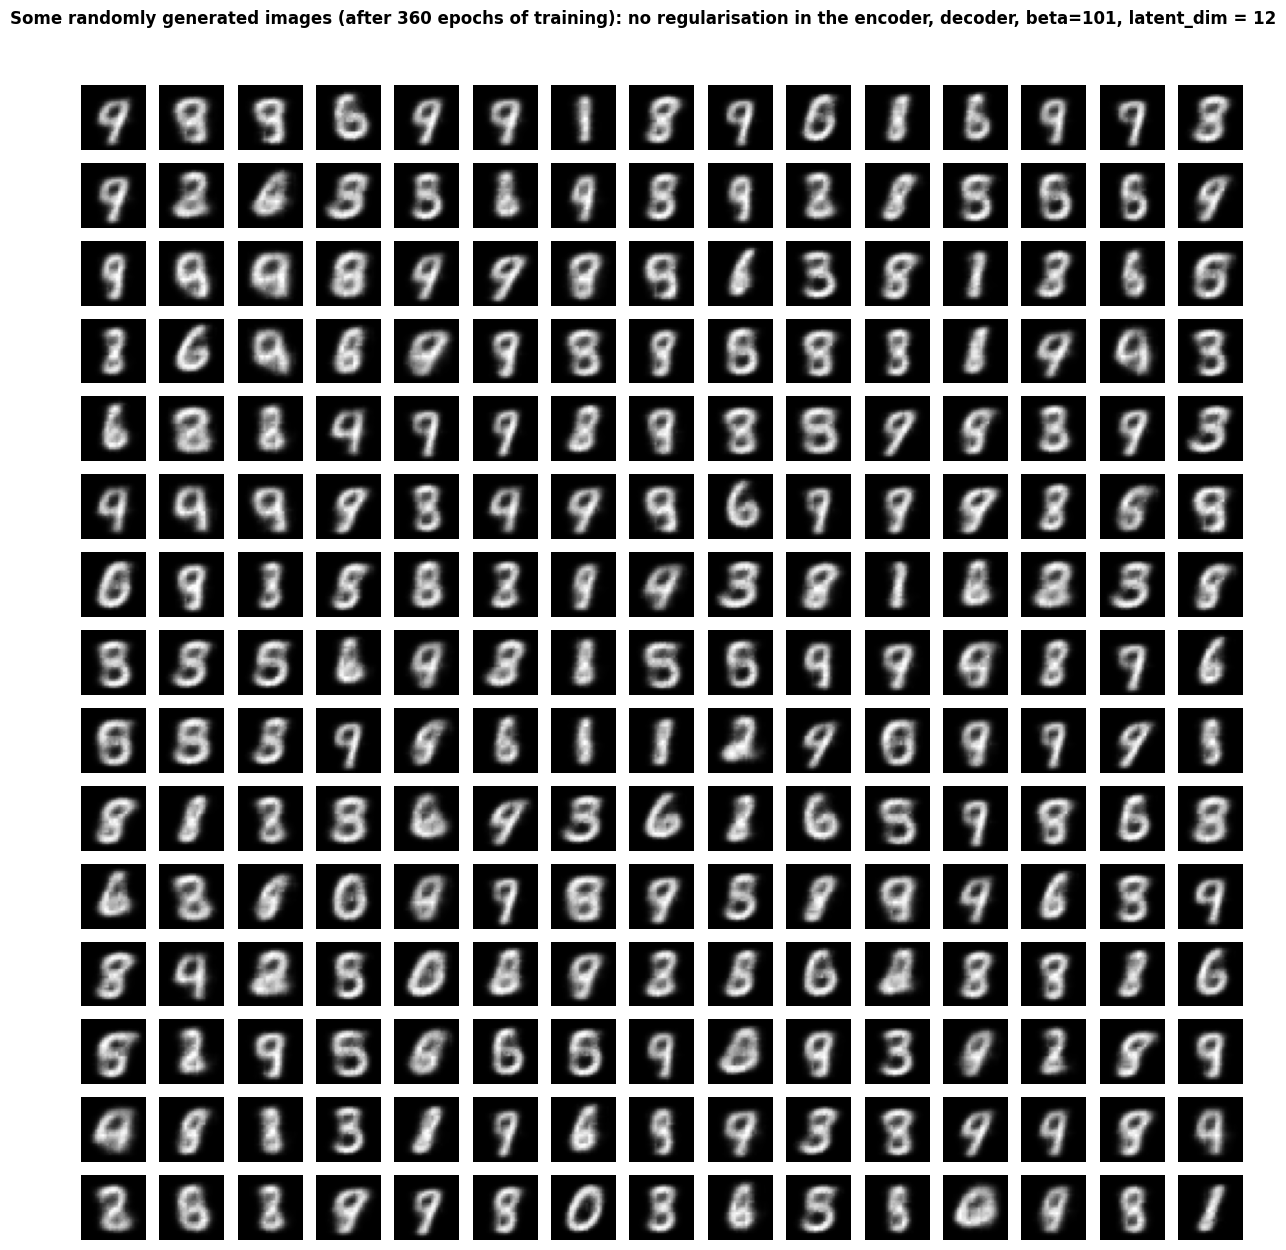

In [45]:
plot_generated(1,15,333,360,10)

the images are too blurry coz of the weight attached to the kl term

## **beta=3**

In [46]:
beta=3

def vae_loss_5(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [47]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=50000, decay_rate=0.994, staircase=True)
optim = keras.optimizers.Adam(learning_rate = 0.001)
VAE.compile(optimizer=optim,loss=vae_loss_5)

In [49]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 149.0626 - val_loss: 147.9904
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 147.8492 - val_loss: 147.6479
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 147.6937 - val_loss: 147.4353
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 147.4410 - val_loss: 146.7505
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 146.7964 - val_loss: 146.1383
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 146.4575 - val_loss: 146.2807
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 146.4812 - val_loss: 147.4011
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 146.1207 - val_loss: 145.4614
Epoch 9/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 145.6816 - val_loss: 145.6532
Epoch 10/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 145.6518 - val_loss: 144.9173
Epoch 11/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 145.6212 - val_loss: 14

In [50]:
optim = keras.optimizers.Adam(learning_rate = 0.0001)        # looks like we got stuck in some local minima with too low of a lr towards the end of the last 500 epochs
VAE.compile(optimizer=optim,loss=vae_loss_5)
history2 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 143.7043 - val_loss: 143.0470
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 142.7361 - val_loss: 142.9702
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 143.3083 - val_loss: 142.8867
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 143.3897 - val_loss: 142.7970
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 143.0992 - val_loss: 142.7291
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.8609 - val_loss: 142.8363
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 143.1083 - val_loss: 142.8530
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.6366 - val_loss: 142.8515
Epoch 9/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 143.2798 - val_loss: 142.7283
Epoch 10/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.9149 - val_loss: 142.8446
Epoch 11/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.8183 - val_l

In [51]:
optim = keras.optimizers.Adam(learning_rate = 0.000015)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history3 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)        # trying to explore nearby with a slightly higher lr

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 142.7203 - val_loss: 142.5594
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.5954 - val_loss: 142.5153
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.9648 - val_loss: 142.5393
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.5786 - val_loss: 142.5132
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.3469 - val_loss: 142.4049
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.8254 - val_loss: 142.4908
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.9672 - val_loss: 142.6287
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.6739 - val_loss: 142.5898
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.9896 - val_loss: 142.5047
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.6966 - val_loss: 142.2711


In [52]:
optim = keras.optimizers.Adam(learning_rate = 0.000009)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history4 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 142.8583 - val_loss: 142.5231
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.3012 - val_loss: 142.4319
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.4363 - val_loss: 142.4041
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 143.2073 - val_loss: 142.5760
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.5267 - val_loss: 142.4764
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 142.7297 - val_loss: 142.5033
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.5324 - val_loss: 142.4986
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 142.6800 - val_loss: 142.3624
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.5444 - val_loss: 142.3581
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.6825 - val_loss: 142.3938


In [53]:
optim = keras.optimizers.Adam(learning_rate = 0.00001)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history5 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 142.6018 - val_loss: 142.3777
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.7298 - val_loss: 142.3745
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.4096 - val_loss: 142.4706
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.6601 - val_loss: 142.5781
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.7968 - val_loss: 142.4258
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.6251 - val_loss: 142.4012
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.4358 - val_loss: 142.3060
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.5578 - val_loss: 142.4604
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.2276 - val_loss: 142.5422
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.6127 - val_loss: 142.4245


In [54]:
optim = keras.optimizers.Adam(learning_rate = 0.000009)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history6 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 142.6204 - val_loss: 142.4078
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.7608 - val_loss: 142.5536
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.6260 - val_loss: 142.4541
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.7061 - val_loss: 142.4770
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.6122 - val_loss: 142.4049
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.5638 - val_loss: 142.4429
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 142.4598 - val_loss: 142.3946
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.7163 - val_loss: 142.3087
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.5177 - val_loss: 142.4377
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 142.6001 - val_loss: 142.3405


In [55]:
optim = keras.optimizers.Adam(learning_rate = 0.0000095)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history7 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 142.5009 - val_loss: 142.4203
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.5990 - val_loss: 142.4225
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 142.2307 - val_loss: 142.4053
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.3799 - val_loss: 142.4491
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.8293 - val_loss: 142.4875
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.4464 - val_loss: 142.6520
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.5194 - val_loss: 142.3892
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.3149 - val_loss: 142.4193
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.1514 - val_loss: 142.3256
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.7834 - val_loss: 142.5272


In [56]:
optim = keras.optimizers.Adam(learning_rate = 0.0000095)
VAE.compile(optimizer=optim,loss=vae_loss_5)
history8 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=30, steps_per_epoch=None)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 142.4205 - val_loss: 142.4297
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.5416 - val_loss: 142.4655
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.2342 - val_loss: 142.3750
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.7542 - val_loss: 142.4121
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.5503 - val_loss: 142.4062
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 142.6818 - val_loss: 142.4272
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 142.6468 - val_loss: 142.4454
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 142.5128 - val_loss: 142.4330
Epoch 9/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 142.8461 - val_loss: 142.5425
Epoch 10/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 142.4705 - val_loss: 142.4358
Epoch 11/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 142.3992 - val_l

The performance on the training set is increasing marginally, but the performance on the validation hasn't improved significantly in a while. We're going to take that as a sign that this is a reasonable place to stop training.

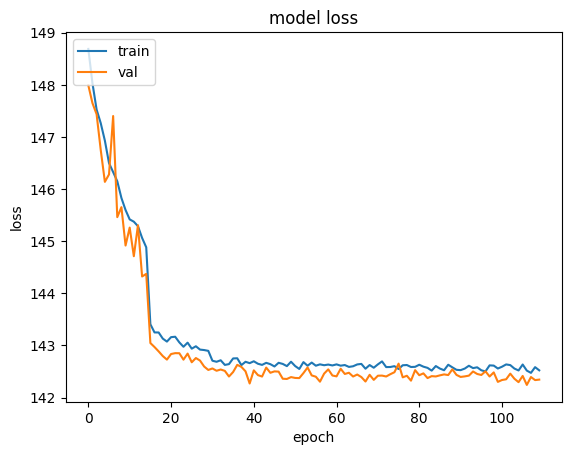

In [57]:
comb_hist_loss = history.history['loss']+ history2.history['loss']+ history3.history['loss']+ history4.history['loss']+ history5.history['loss']+ history6.history['loss']+ history7.history['loss']+ history8.history['loss']
comb_hist_val_loss = history.history['val_loss']+ history2.history['val_loss']+ history3.history['val_loss']+ history4.history['val_loss']+ history5.history['val_loss']+ history6.history['val_loss']+ history7.history['val_loss']+ history8.history['val_loss']

plt.plot(comb_hist_loss)
plt.plot(comb_hist_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

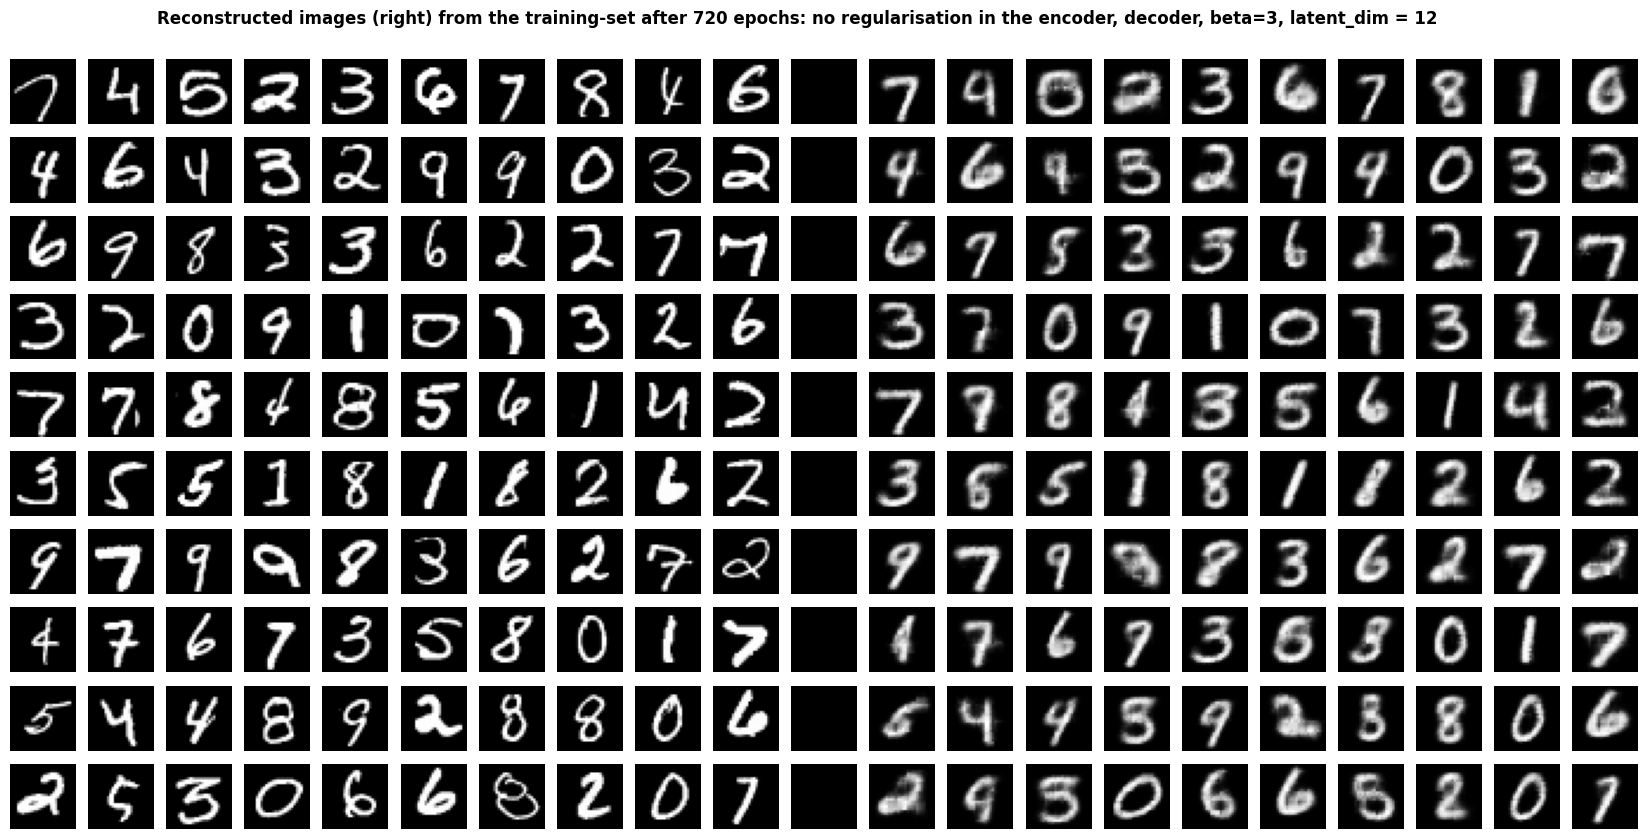

In [58]:
plot_reconstruction(img_train,'training',111,720,3)

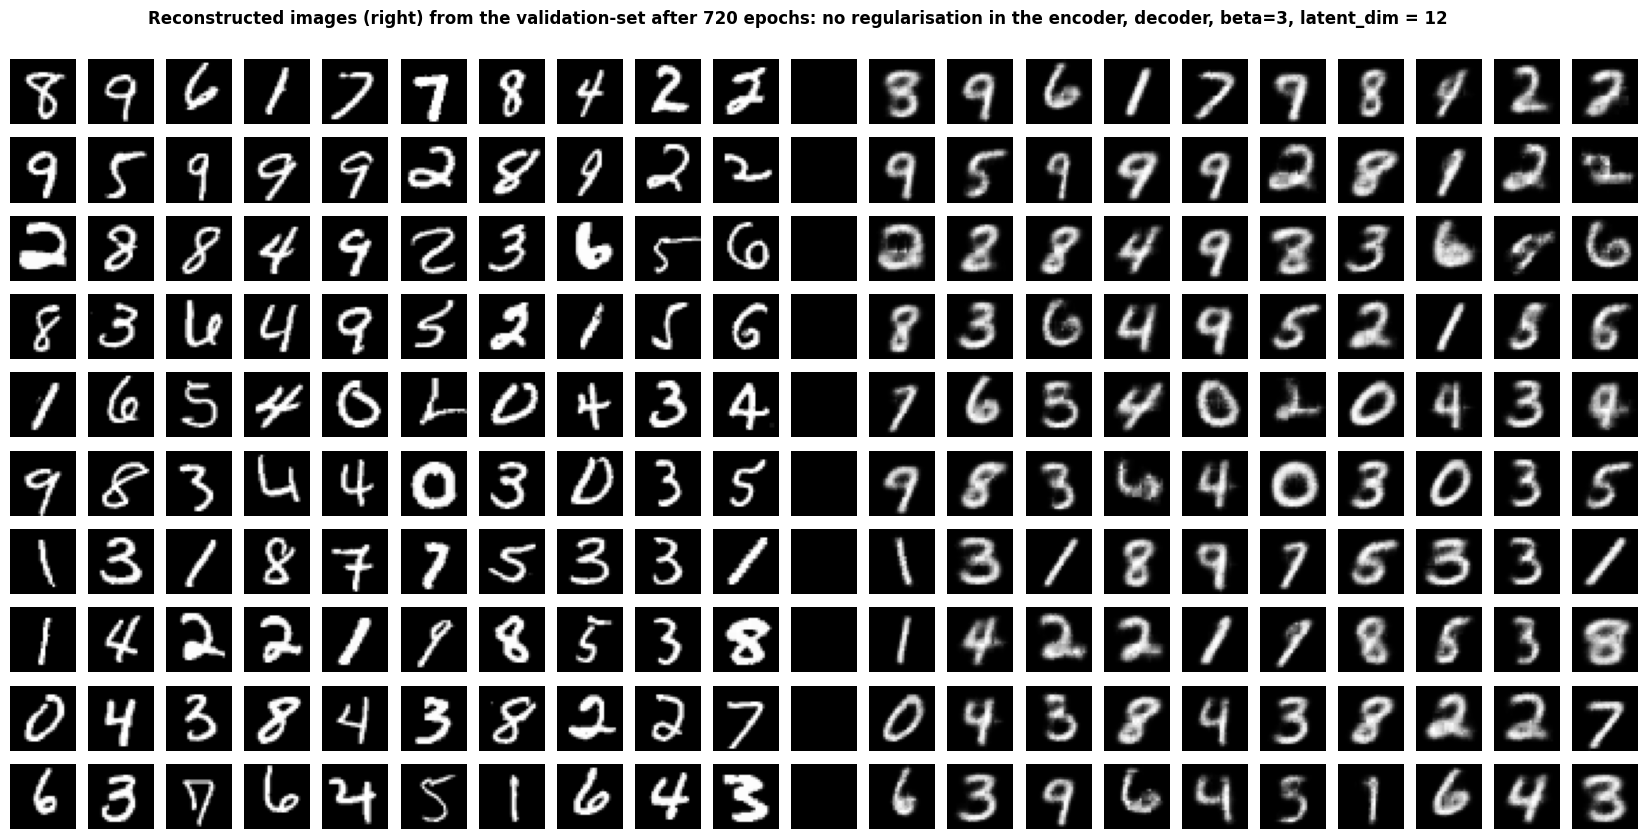

In [59]:
plot_reconstruction(img_valid,'validation',111,720,3)

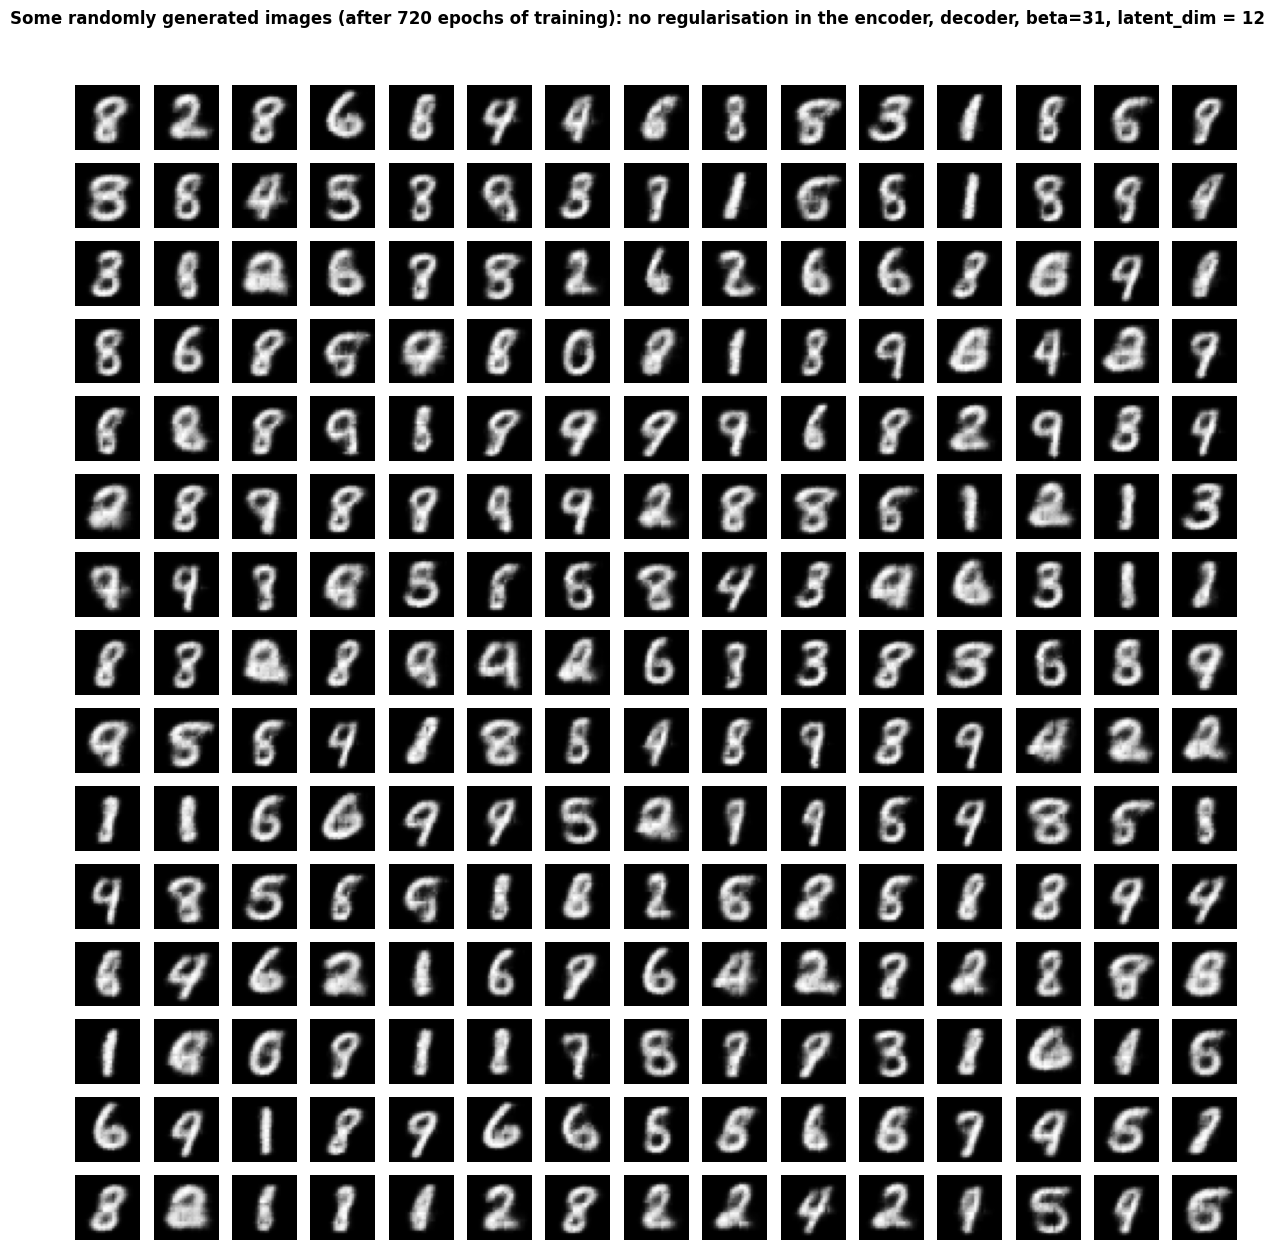

In [60]:
plot_generated(1,15,123,720,3)

The improvement from beta=1 to beta=3 (the model with the latter should be equally well-trained if not a little better than the previous) seems to be that the quality is more averaged out and uniform, especially for the generated images. The generated images are a little smoother but also more blurry (which is expected I guess).